In [198]:
# Using https://towardsdatascience.com/building-an-image-similarity-search-engine-with-faiss-and-clip-2211126d08fa

In [344]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import math 
import shutil
import scipy

### FIASS HELPER FUNCTIONS

In [354]:
def generate_clip_embeddings(images_path, model):
            
    image_paths = glob(os.path.join(images_path, '**/*.png'), recursive=True)
    
    embeddings = []
    for img_path in image_paths:
        image = Image.open(img_path)
        embedding = model.encode(image)
        embeddings.append(embedding)
    
    return embeddings, image_paths

def create_faiss_index(embeddings, image_paths, output_path):
      
    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)
    
    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))
    
    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")
    
    # Save image paths
    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')
    
    return index


def load_faiss_index(index_path):
      index = faiss.read_index(index_path)
      with open(index_path + '.paths', 'r') as f:
            image_paths = [line.strip() for line in f]
      print(f"Index loaded from {index_path}")
      return index, image_paths


def retrieve_similar_images(query, model, index, image_paths, top_k=3):
          
    # query preprocess:
    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images, distances



def visualize_results(query, retrieved_images, distances):
      plt.figure(figsize=(12, 5))

      # If image query
      if isinstance(query, Image.Image):
            plt.subplot(1, len(retrieved_images) + 1, 1)
            plt.imshow(query)
            plt.title("Query Image")
            plt.axis('off')
            start_idx = 2

      # If text query
      else:
            plt.subplot(1, len(retrieved_images) + 1, 1)
            plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
            plt.axis('off')
            start_idx = 2

      # Display images
      for i, img_path in enumerate(retrieved_images):

            plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
            plt.imshow(Image.open(img_path))
            plt.title(f"Match {i + 1} Sim: {distances[i]} ")
            plt.axis('off')

      plt.show()

### Get HEX PICTURES AND CREATE FIASS INDEXES

In [ ]:
hex_radius = 10
IMAGES = ['2016','2018']
VERBOSE = False


def hex_corner(center, size, i):
      """Helper function to calculate hexagon corners."""
      angle_deg = 60 * i
      angle_rad = math.pi / 180 * angle_deg
      return (center[0] + size * math.cos(angle_rad), center[1] + size * math.sin(angle_rad))

def crop_hexagon(hex_image,center):
      """Crop Hexagons from hex image around center """
      
      corners = [hex_corner(center, hex_radius, i) for i in range(6)]
      mask = Image.new("RGBA", (hex_image.size[0],hex_image.size[1]))
      draw = ImageDraw.Draw(mask)
      draw.polygon(list(corners), fill='green', outline='red')
      
      background = Image.new("RGBA", hex_image.size, (0,0,0,0))
      new_img = Image.composite(hex_image, background, mask)
      return new_img

#
def get_hexagons():
      """Get PIL images of each hexagon region"""
      hex_segments = []
      hex_pos = []
      hex_image = img
      for q in range(size_height):
            for r in range(size_width):
                  x = r * (hex_width - (math.cos(1.0472) * hex_radius)) 
                  y = q * (hex_height) + ((r%2) * math.sin(1.0472) * hex_radius) 
                  hex_image = crop_hexagon(img, (x, y))
                  hex_segments.append(hex_image)
                  hex_pos.append([x,y])

      return hex_segments, hex_pos


for IMAGE in IMAGES:
      img = Image.open(f'./../images/{IMAGE}.png')
      hex_height = math.sqrt(3) * hex_radius
      hex_width = 2 * hex_radius
      size = img.size[0] // hex_width
      size_width = math.ceil(img.size[1] / hex_height ) +2
      size_height = math.ceil(img.size[0] / hex_width) +2

      # Get hexagonal segments and their positions
      hexagons, positions = get_hexagons()


      DIR = f'./../images/{IMAGE}/'
      if(os.path.exists(DIR) and os.path.isdir(DIR)):
            shutil.rmtree(DIR,'r')
      os.mkdir(DIR)


      #Save all hexagons images into local directory
      for (x, y), hex_img in zip(positions, hexagons):
            imageBox = hex_img.getbbox()
            cropped = hex_img.crop(imageBox)
            
            cropped.save(f'./../images/{IMAGE}/{x}_{y}.png')

      


      
      print(f'DONE CROPPING {IMAGE}')
      # Plot each hexagon in its correct position
      if(VERBOSE):
            # Visualization with matplotlib
            fig, ax = plt.subplots()
            ax.set_aspect('equal')
            for (x, y), hex_img in zip(positions, hexagons):
                  ax.imshow(hex_img.resize((hex_img.size[0]-10,hex_img.size[1]-10)))

            ax.set_xlim(0, img.size[0])
            ax.set_ylim(img.size[1], 0)
            ax.axis('off')

            plt.show()
      
      """Create IMAGE EMBEDDINGS FROM FIASS
      """
      IMAGES_PATH = f'./../images/{IMAGE}/'
      OUTPUT_INDEX_PATH = f'./../images/{IMAGE}/indexes/'
      
      
      
      
      if(os.path.exists(OUTPUT_INDEX_PATH) and os.path.isdir(OUTPUT_INDEX_PATH)):
            shutil.rmtree(OUTPUT_INDEX_PATH,'r')
      os.mkdir(OUTPUT_INDEX_PATH)
      
      model = SentenceTransformer('clip-ViT-B-32')
      
      
      embeddings, image_paths = generate_clip_embeddings(IMAGES_PATH, model)
      
      index = create_faiss_index(embeddings, image_paths, OUTPUT_INDEX_PATH+'index')
      print(f'DONE INDEXING {IMAGE}')




DONE 2016
Index created and saved to ./../images/2016/indexes/index
DONE 2018


### TEST COMPARISION

Index loaded from ./../images/2016/indexes/index


(array([1., 2., 4., 3., 4., 5., 6., 7., 3., 1.]),
 array([   0.        ,  121.19422428,  242.38844857,  363.58267285,
         484.77689714,  605.97112142,  727.16534571,  848.35956999,
         969.55379428, 1090.74801856, 1211.94224285]),
 <BarContainer object of 10 artists>)

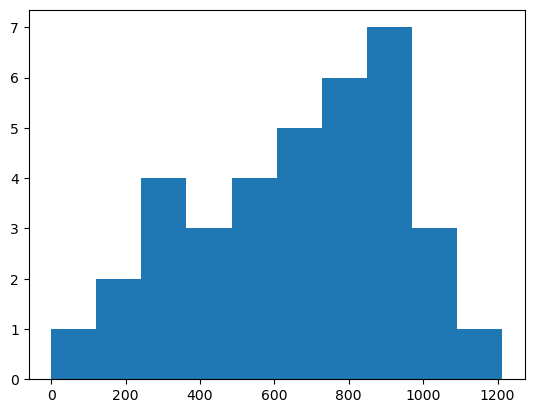

In [369]:

REFRENCE_INDEX_PATH = f'./../images/{2016}/indexes/index'
QUERY_INDEX_PATH = f'./../images/{2018}/'
index, image_paths = load_faiss_index(REFRENCE_INDEX_PATH)

differences = []
for image in os.listdir(QUERY_INDEX_PATH):
      if('.png' in image):
            
            true_coord_x = float(image.split('.')[0])
            true_coord_y = float(image.split('.')[1].split('_')[1])
            pred_coord_x = []
            pred_coord_y = []
            
            query = f'{IMAGES_PATH}{image}'
            
            
            query2, retrieved_images, distances = retrieve_similar_images(query, model, index, image_paths, top_k=5)
            distances = distances[0]
            distances = distances/(distances).mean()
            for image, distance in zip(retrieved_images, distances):
                  image = image.split('/')[-1]
                  retreived_coord_x = float(image.split('.')[0])
                  retreived_coord_y = float(image.split('.')[1].split('_')[1])
                  true_coord_x_with_error = true_coord_x * np.random.normal(1,1)
                  true_coord_y_with_error = true_coord_y * np.random.normal(1,1)
                  
                  diff = math.sqrt((true_coord_x_with_error - retreived_coord_x) ** 2 + (true_coord_y_with_error - retreived_coord_y)**2)
                  # weight = np.exp(-distance)
                  weight = np.exp(-diff)
                  pred_coord_x.append(retreived_coord_x*weight)
                  pred_coord_y.append(retreived_coord_y*weight)
            pred_coord_x = np.asarray(pred_coord_x).mean()
            pred_coord_y = np.asarray(pred_coord_y).mean()
            
                  
            
            diff = math.sqrt((int(true_coord_x) - int(pred_coord_x)) ** 2 + (int(true_coord_y) - int(pred_coord_y))**2)
            differences.append(diff)
            # if (diff < 100):
            #       visualize_results(query2, retrieved_images, distances)
            
plt.hist(differences)
      
      
      
      

In [353]:
# query ='/Users/ethanweilheimer/school/research/gpd-denied-navigation/images/2018/0.0_571.5767664977294.png'
# query, retrieved_images, distances = retrieve_similar_images(query, model, index, image_paths, top_k=3)
# visualize_results(query, retrieved_images, distances[0])